In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import torch_geometric.transforms as T
import GraphNN as G

from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm

/lhome/ific/f/fkellere/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#file = "out_job_20250312_150538/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #Best performance new MC RadiusGraph no transform
#file = "out_job_20250407_152716/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #New MC KNN 8 neighbors
#file = "out_job_20250328_170857/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #New MC RadiusGraph with transform
#file = "out_job_20250407_175322/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #New MC Fully Connected
#file = "/lhome/ific/j/jrenner/gnn/out_job_20250402_182028/Loss_LargeNEWMC_LMDB.h5"
#file = "out_job_20250328_112257/Loss_RecoBig_all_10mm_R2.h5" #old MC with transform
#file = "out_job_20250408_150837/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #KNN 6 neighbors
#file = "out_job_20250411_110106/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #KNN 20 neighbors
#file = "out_job_20250414_120047/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #KNN 10 neighbors
#file = "out_job_20250416_122426/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #KNN 15 neighbors
#file = "out_job_20250414_142609/Loss_RecoNew_all_10mm_R2.h5" #KNN 10 neighbors VoxOpt (very bad!)
#file = "out_job_20250414_172230/Loss_RecoNew_all_10mm_KNN_hitsopt.h5" #KNN 10 neighbors node deletion pre-transform
#file = "out_job_20250422_124444/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #KNN 8 neighbors node deletion transform at the end
#file = "out_job_20250429_100740/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #KNN 10 neighbors node deletion at the beginning
#file = "out_job_20250502_121635/Loss_RecoNew_all_10mm_KNN_hitsopt.h5" #KNN 10 neighbors node deletion at the end
#file = "out_job_20250513_160535/Loss_RecoNew_all_10mm_KNN6_hitsopt.h5"
#file = "out_job_20250513_160232/Loss_RecoNew_all_10mm_KNN_hitsopt.h5"
#file = "out_job_20250513_161146/Loss_RecoNew_all_10mm_KNN20_hitsopt.h5"
file = "out_job_20250514_122809/Loss_RecoNew_all_10mm_FC_hitsopt.h5"
# Load the data
y_test  = pd.read_hdf(file,'y_test')
y_pred  = pd.read_hdf(file,'y_predict_test')
Ltrain  = pd.read_hdf(file,'loss_train')
Lvalid  = pd.read_hdf(file,'loss_valid')

y_pred = np.exp(y_pred)/(1+np.exp(y_pred))

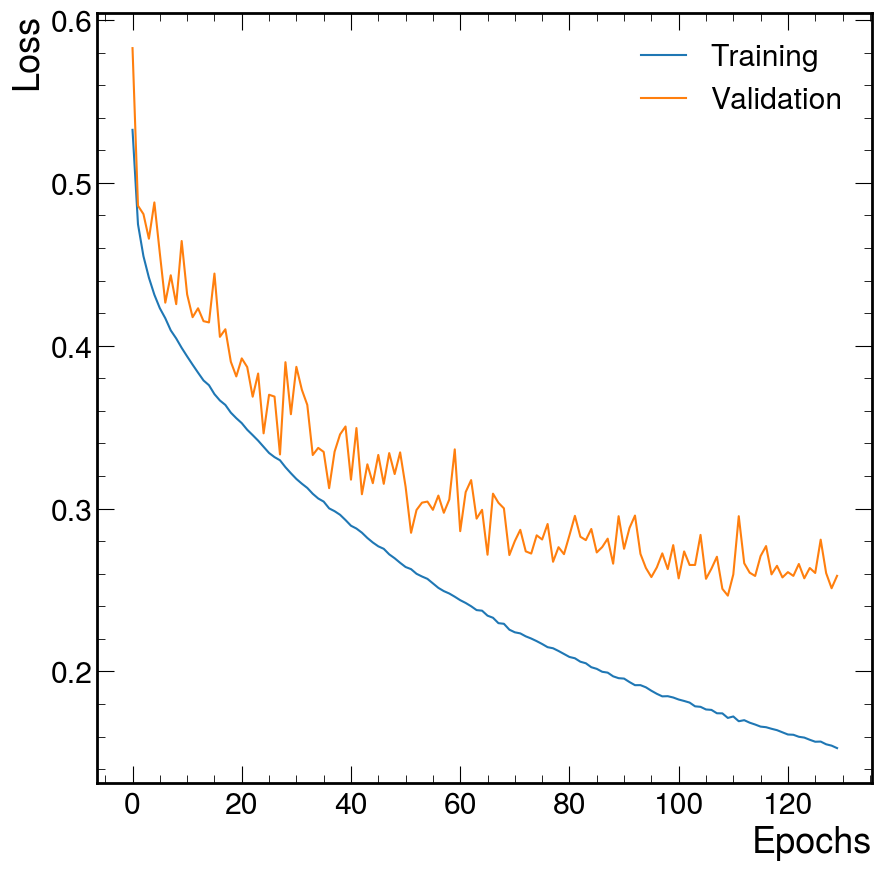

In [4]:
plt.style.use(hep.style.ROOT)
plt.plot(Ltrain,label='Training')
plt.plot(Lvalid,label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,1])
plt.legend()

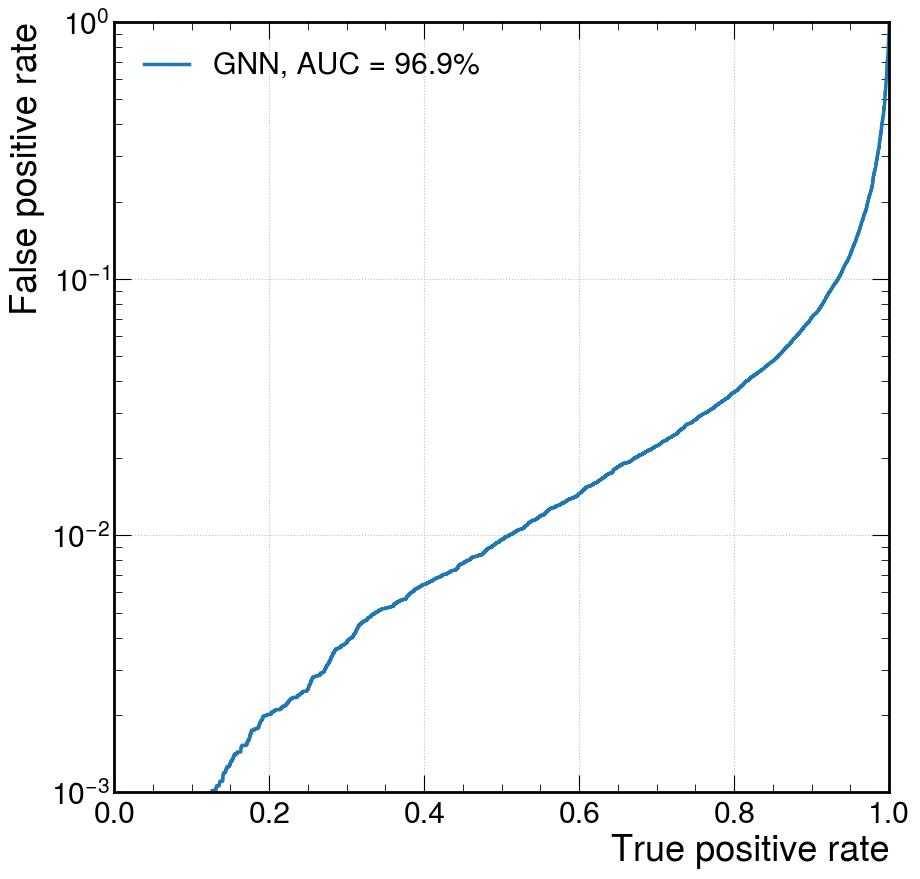

In [5]:
plt.style.use(hep.style.ROOT)
# create ROC curves
try:
    fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
    y_test = y_test.to_numpy()
    y_pred = y_pred.to_numpy()
except:
    y_test = np.array(y_test).flatten()
    y_pred = np.array(y_pred['Predicted Probability Class 1']).flatten()
    fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
    
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

  0%|          | 0/68837 [00:00<?, ?it/s]

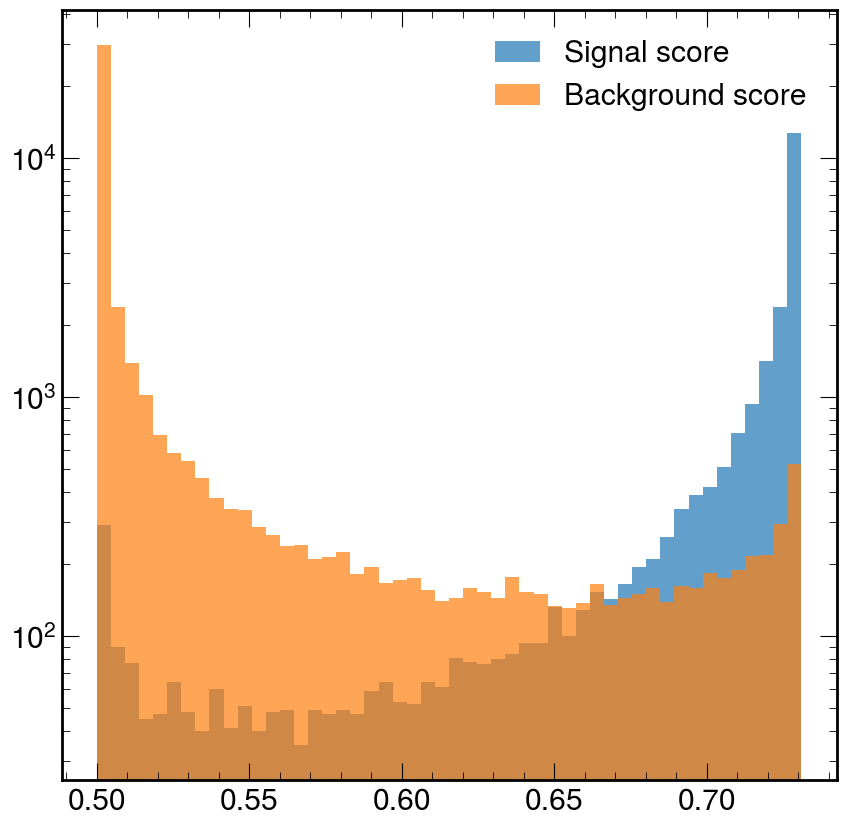

In [6]:
B_score = []
S_score = []
t = tqdm(range(0, len(y_pred)))

for i in t:
    if y_test[i]==0:
        B_score.append(y_pred[i])
    else:
        S_score.append(y_pred[i])
        
plt.hist(S_score, 50, label='Signal score', alpha=0.7)
plt.hist(B_score, 50, label='Background score', alpha=0.7)
plt.semilogy()
plt.legend()

  0%|          | 0/100 [00:00<?, ?it/s]

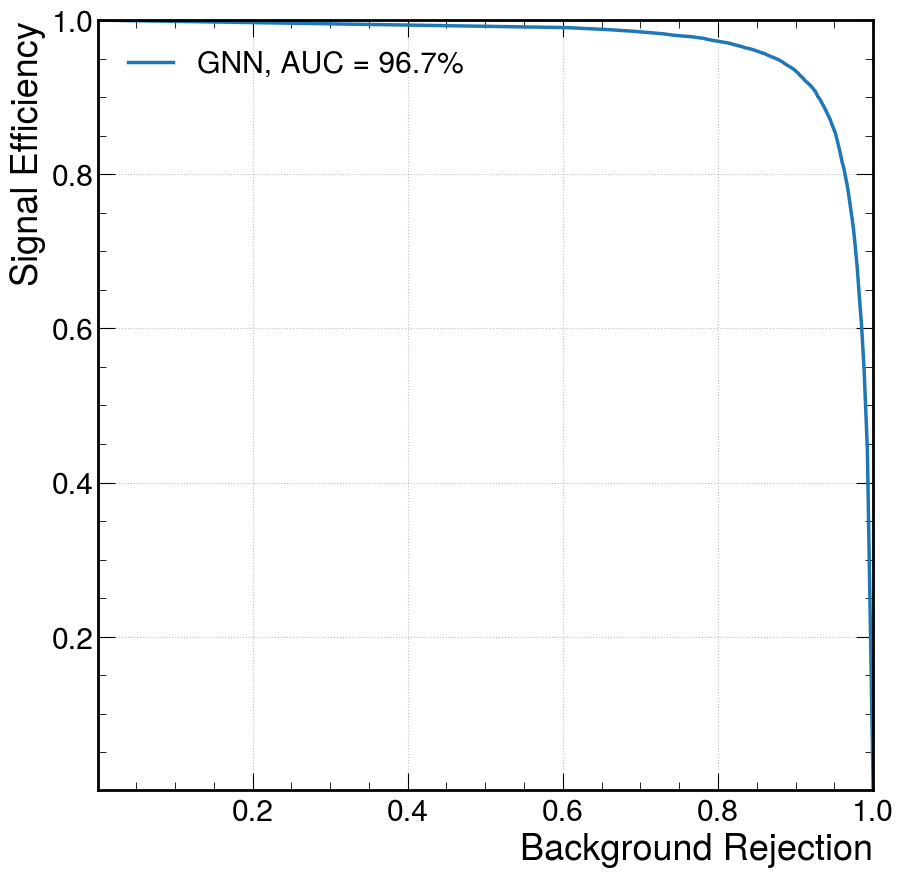

In [7]:
Seff = []
Brej = []
Figm = []
thre = np.linspace(min(y_pred),max(y_pred),100)
t    = tqdm(range(0,len(thre)))

for i in t:
    Seff.append(len([x for x in S_score if x>=thre[i]])/len(S_score))
    Brej.append(1-len([x for x in B_score if x>=thre[i]])/len(B_score))
    Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/
            (np.sqrt(len([x for x in B_score if x>=thre[i]]))*len(S_score)))
    
plt.figure()
plt.plot(Brej, Seff, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(Brej,Seff)*100))
plt.xlabel(r'Background Rejection')
plt.ylabel(r'Signal Efficiency')
#plt.semilogx()
plt.ylim(0.001, 1)
plt.xlim(0.001, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

/tmp/fkellere/ipykernel_53094/4116716709.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(threshold_gnn,tpr_gnn/np.sqrt(fpr_gnn))


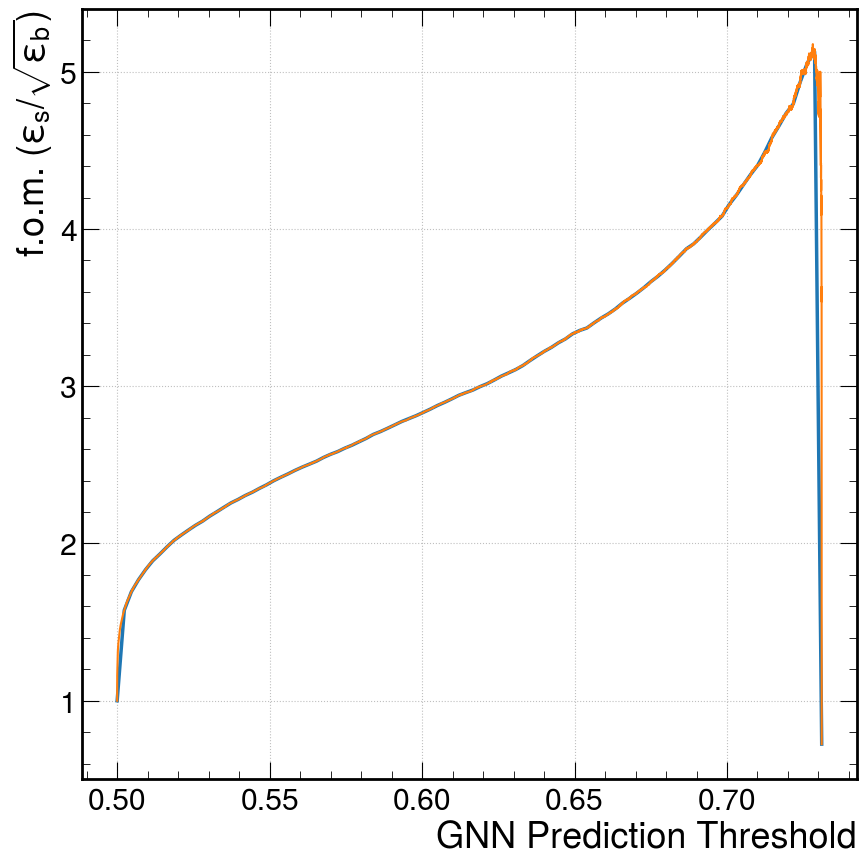

In [8]:
plt.figure()
plt.plot(thre, Figm, lw=2.5)
plt.plot(threshold_gnn,tpr_gnn/np.sqrt(fpr_gnn))
plt.xlabel(r'GNN Prediction Threshold')
plt.ylabel(r'f.o.m. ($\epsilon_{s}/\sqrt{\epsilon_{b}}$)')
plt.grid(True)
plt.show()

In [9]:
Fom  = [x for x in Figm if x!=np.inf]
Seff[np.argmax(Fom)]

0.44330467353366815

In [10]:
Brej[np.argmax(Fom)]

0.9925236530445714

In [11]:
max(Fom)

5.126932340072654

In [12]:
thre_GCN = thre
Figm_GCN = Figm
Seff_GCN = Seff
Brej_GCN = Brej
%store thre_GCN
%store Figm_GCN
%store Seff_GCN
%store Brej_GCN

Stored 'thre_GCN' (ndarray)
Stored 'Figm_GCN' (list)
Stored 'Seff_GCN' (list)
Stored 'Brej_GCN' (list)


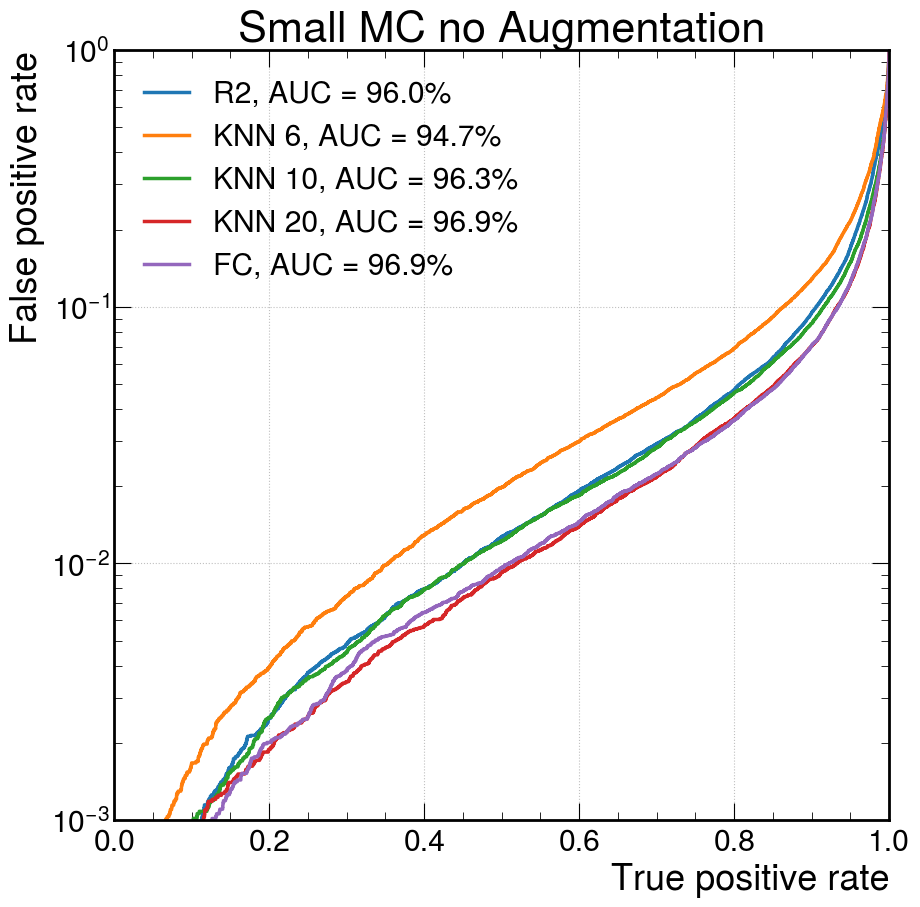

In [13]:
files = [
    "out_job_20250312_150538/Loss_RecoNew_all_10mm_R2_hitsopt.h5", 
    "out_job_20250513_160535/Loss_RecoNew_all_10mm_KNN6_hitsopt.h5", 
    "out_job_20250513_160232/Loss_RecoNew_all_10mm_KNN_hitsopt.h5", 
    "out_job_20250513_161146/Loss_RecoNew_all_10mm_KNN20_hitsopt.h5", 
    "out_job_20250514_122809/Loss_RecoNew_all_10mm_FC_hitsopt.h5"
]
labels = [
    "R2",
    "KNN 6",
    "KNN 10",
    "KNN 20",
    "FC"
]
for i in range(len(files)):
    file = files[i]
    y_test  = pd.read_hdf(file,'y_test')
    y_pred  = pd.read_hdf(file,'y_predict_test')
    Ltrain  = pd.read_hdf(file,'loss_train')
    Lvalid  = pd.read_hdf(file,'loss_valid')

    y_pred = np.exp(y_pred)/(1+np.exp(y_pred))

    # create ROC curves
    try:
        fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
        y_test = y_test.to_numpy()
        y_pred = y_pred.to_numpy()
    except:
        y_test = np.array(y_test).flatten()
        y_pred = np.array(y_pred['Predicted Probability Class 1']).flatten()
        fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
    # plot ROC curves
    plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label=f"{labels[i]},"+" AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100))
    plt.xlabel(r'True positive rate')
    plt.ylabel(r'False positive rate')
    plt.semilogy()
    plt.ylim(0.001, 1)
    plt.xlim(0, 1)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title('Small MC no Augmentation')